In [2]:
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import json
import os
import pandas as pd
import pandas as pd
from rdkit import Chem
import torch
import numpy as np
from torch.utils.data import Dataset
import pickle
from collections import defaultdict
from pathlib import Path
import torch.nn.functional as F
import pickle
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import json
import os
import pandas as pd
import pandas as pd
from rdkit import Chem
import torch
import numpy as np
from torch.utils.data import Dataset
import pickle
from collections import defaultdict
from pathlib import Path
import torch.nn.functional as F
import pickle
import json 

In [3]:
%run ../Config.ipynb
config = Config()
pdbs = os.listdir(config.set)
nposes = config.docking_params['nposes']
batch_size  = config.model_args['batch_size']
path_scripts = Path(os.getcwd())
num_epochs = config.model_args['epochs']
num_folds = config.model_args['nfolds']
patience = config.model_args['patience']  # Set your desired patience value
binana_executable = config.executables['binana']

#### Functions 

In [4]:
def filter_and_print_label_distribution(dataset_list_final):
    filtered_data_list_num_nodes = [data for data in dataset_list_final if data.num_nodes > 0]
    filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
    filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[0, 2].isnan()] 
    filtered_data_list = filtered_data_list_descriptors.copy()
    
    label_distribution = dict(Counter([label.y.tolist() for label in filtered_data_list]))
    amount_of_graphs_used_to_train = len(filtered_data_list)
    
    print("Label Distribution:")
    for label, count in label_distribution.items():
        print(f"Label {label}: {count}")
    
    print(f"Amount of Graphs Used to Train: {amount_of_graphs_used_to_train}")
    
    return filtered_data_list

In [5]:
def save_list_to_file(data_list, config, name):
    with open(f'{config.data}/{name}', 'wb') as file:
        pickle.dump(data_list, file)
        print(f'Saved {name} with success!')

def open_file(config, name):
    with open(f'../Datahub/Data/{name}', 'rb') as file:
        bipartite_data = pickle.load(file) 

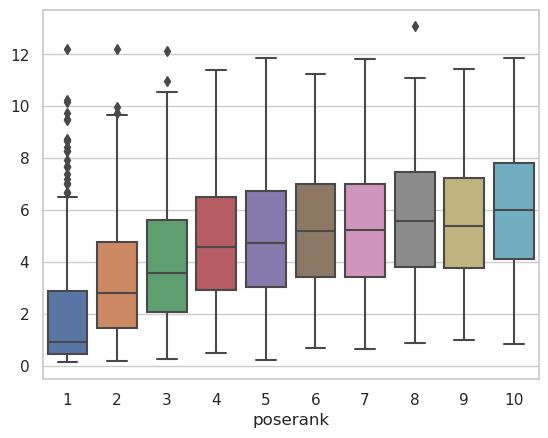

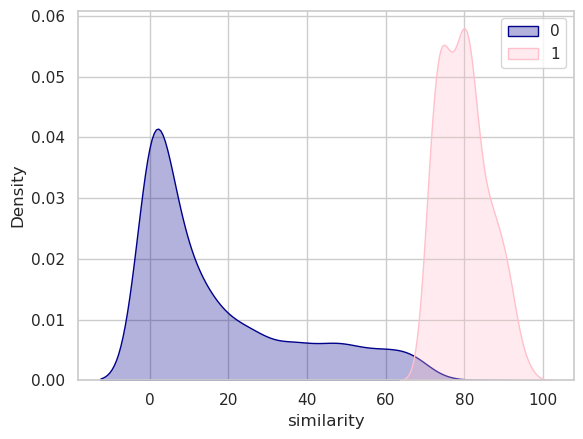

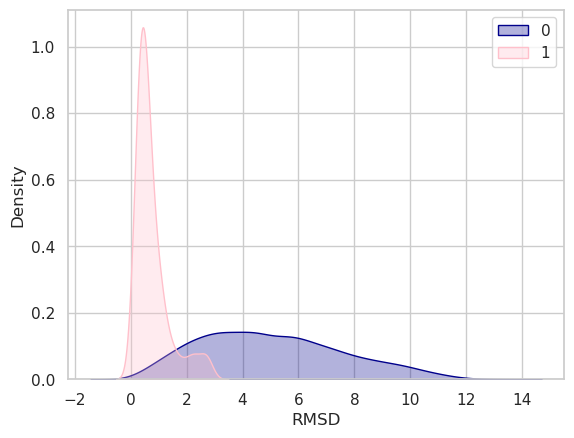

label.json saved at: ../Datahub/Data


/tmp/ipykernel_5458/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_5458/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_5458/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_5458/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_5458/

284

In [164]:
%run Label.ipynb
label = pd.read_json(f"{config.data}/label.json").fillna(0)
len(label.columns)

#### Get_dataset

In [5]:
with open(f'{config.root}/{config.project_name}/{config.dicts}/combined_dicts_atoms_prop.pkl','rb') as f:
        combined_dict_atoms_prop = pickle.load(f)

In [21]:
%%time
class Get_dataset():
    def __init__(self, pdbs, lig_atoms_prop, rec_atoms_prop, df_dict, subsample=None, preprocessed_protgraph=False):
        self.pdbs = pdbs
        self.lig_atoms_prop = combined_dict_atoms_prop['lig_atoms_prop']
        self.rec_atoms_prop = combined_dict_atoms_prop['rec_atoms_prop']
        self.df_dict = combined_dict_atoms_prop['df_dict']
        self.protgraph_dict = self.get_unique_prot_graphs()
        self.preprocessed_protgraph=preprocessed_protgraph
        self.subsample = subsample 

        
    def map_node_names_to_indices(self, edge_index):
        unique_node_names_0, node_name_to_index_0 = torch.unique(edge_index[0], sorted=True, return_inverse=True)
        unique_node_names_1, node_name_to_index_1 = torch.unique(edge_index[1], sorted=True, return_inverse=True)
    
        # Map the node names to their corresponding indices separately for edge_index[0] and edge_index[1]
        updated_edge_index_0 = node_name_to_index_0.view(1, -1)
        updated_edge_index_1 = node_name_to_index_1.view(1, -1)
    
        # Combine the updated edge indices back into the same format as edge_index
        updated_edge_index = torch.cat((updated_edge_index_0, updated_edge_index_1), dim=0)
    
        return updated_edge_index
        
    def get_unique_prot_graphs(self):
        protgraph_dict = {}
        failed_protgraph = []

        for pdb in self.pdbs:
            protgraph_dict[pdb] = {}
            for pose in range(1, nposes + 1):
                try:
                    x_s = torch.tensor(np.array(self.lig_atoms_prop[pdb][pose].iloc[:, 1:].astype("float32")))
                    x_t = torch.tensor(np.array(self.rec_atoms_prop[pdb][pose].iloc[:, 1:].astype("float32")))
                    edge_index = torch.tensor(np.array([self.df_dict[pdb][pose]["ligand_atom_index"].astype("int64"),
                                                    self.df_dict[pdb][pose]["receptor_atom_index"].astype("int64")]))
                
                    edge_index = self.map_node_names_to_indices(edge_index)
                    distances = torch.tensor(np.array(self.df_dict[pdb][pose]['distance']).astype("float32"))
                    #print('x_s: ', x_s)
                    protgraph_dict[pdb][pose] = {'x_s': x_s, # Ligand
                                             'x_t': x_t, # Receptor
                                             'edge_index': edge_index,
                                             'edge_attr': distances,
                                             }
                except Exception as e:
                    #print('Error')
                    continue
        return protgraph_dict


    def process(self):
        print('processessing....')
        if self.preprocessed_protgraph:
            with open(f'{config.root}/{config.project_name}/{config.dicts}/protgraph_dict.pkl','rb') as f:
               protgraph_dict = pickle.load(f)
        else:
            protgraph_dict = self.get_unique_prot_graphs()
            with open(f'{config.root}/{config.project_name}/{config.dicts}/protgraph_dict.pkl','wb') as f:
                pickle.dump(protgraph_dict,f)
         
        for pdb in tqdm(pdbs, desc = 'PDBs'):
            for pose in range(1, nposes + 1): 

                try: 
                             #  self.protgraph_dict[pdb][pose]
                    protgraph = protgraph_dict[pdb][pose] ### Needs alteration to open saved dict, lets got with it righ now
    
                    interaction_id = str(pdb) + "_" + str(pose)                 
         
                    x_s, x_t, edge_index, edge_attr= protgraph['x_s'], protgraph['x_t'], protgraph['edge_index'],protgraph['edge_attr']
    
                    #y = torch.randint(2, (1,), dtype=torch.float32)
                    try:
                        y = torch.tensor(label[pdb][pose], dtype=torch.float32)
                    except Exception as e:
                        print(f"Error: {e}")
                        continue
                    #y = label[pdb][pose].astype("float32")
                    data = BipartiteData(edge_index=edge_index, x_s=x_s, x_t=x_t, y=y, edge_attr = edge_attr, pdb = pdb, pose = pose)
                    #print(f'saving data {config.processed_dir}')
                    torch.save(data, os.path.join(config.processed_dir, f'data_{interaction_id}.pt'))  

                except Exception as e:
                    #print(f"Error: {e}")
                    continue

    
    def processed_file_names(self):
        datalist =   [torch.load(os.path.join(config.processed_dir, f'{filename}')) for filename in os.listdir(config.processed_dir)]
        random.shuffle(datalist)
        return datalist

   # def __len__(self):
   #     return len(protgraph_dict)  ###
   # 
   #def __getitem__(self, index):
   #    pdb = self.pdbs[index]
   #    pose = 1  # You may need to modify this
   #    data_sample = self.protgraph_dict[pdb][pose]
   #    return data_sample

  

dataset = Get_dataset(pdbs, combined_dict_atoms_prop['lig_atoms_prop'], combined_dict_atoms_prop['rec_atoms_prop'], combined_dict_atoms_prop['df_dict'])

NameError: name 'combined_dict_atoms_prop' is not defined

In [25]:
for filename in os.listdir(config.processed_dir):
    print(filename)

data_1nc1_5.pt
data_1w4o_3.pt
data_3e93_8.pt
data_3b5r_6.pt
data_5c2h_9.pt
data_1e66_1.pt
data_4kzu_7.pt
data_3g2n_10.pt
data_3b27_8.pt
data_1pxn_4.pt
data_3d6q_3.pt
data_4j28_7.pt
data_3arp_10.pt
data_3pyy_10.pt
data_1mq6_5.pt
data_3oe5_3.pt
data_1g2k_2.pt
data_3gy4_3.pt
data_3d4z_7.pt
data_4djv_3.pt
data_2al5_4.pt
data_1h22_9.pt
data_4eor_6.pt
data_4mgd_4.pt
data_2vvn_10.pt
data_2xii_6.pt
data_3u5j_1.pt
data_1oyt_4.pt
data_2y5h_8.pt
data_2v7a_2.pt
data_2zda_4.pt
data_3dx2_5.pt
data_3g2z_7.pt
data_1o0h_6.pt
data_4w9i_10.pt
data_4crc_3.pt
data_4qd6_8.pt
data_3fv2_8.pt
data_4f3c_4.pt
data_3uev_1.pt
data_4twp_1.pt
data_4cig_2.pt
data_3pww_8.pt
data_3dx1_2.pt
data_2wnc_9.pt
data_3dd0_10.pt
data_4kzq_1.pt
data_2j78_3.pt
data_3acw_8.pt
data_3qgy_4.pt
data_4llx_1.pt
data_4eo8_6.pt
data_4mme_3.pt
data_3f3e_7.pt
data_3dxg_2.pt
data_2al5_2.pt
data_3ary_8.pt
data_3uev_8.pt
data_4crc_5.pt
data_4u4s_2.pt
data_3b5r_10.pt
data_2cbv_4.pt
data_1z9g_10.pt
data_1h23_7.pt
data_3ebp_2.pt
data_3g2z_6.pt
da

#### BipartiteData

In [6]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None, y=None, edge_attr=None, pdb = None, pose = None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
        self.y = y
        self.edge_attr = edge_attr  # Add edge_attr attribute
        #self.num_nodes = len(set(edge_index[0].tolist())) +  len(set(edge_index[1].tolist()))
        self.num_nodes = (x_s.size(0) if x_s is not None else 0) + (x_t.size(0) if x_t is not None else 0)
        self.pdb = pdb
        self.pose = pose
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)

#### Dataset_list

In [27]:
%%time
dataset.process()
dataset_list = dataset.processed_file_names()

processessing....


PDBs: 100%|██████████████████████████████████| 284/284 [00:01<00:00, 179.86it/s]


CPU times: user 6.59 s, sys: 436 ms, total: 7.02 s
Wall time: 7.08 s


In [28]:
len(dataset_list)

2840

In [2]:
#config.node_descriptors

In [30]:
for test in dataset_list:
    if test.pdb == '4eor':
        print(test)

BipartiteData(edge_index=[2, 88], x_s=[88, 7], x_t=[88, 7], y=0.0, edge_attr=[88], num_nodes=176, pdb='4eor', pose=1)
BipartiteData(edge_index=[2, 61], x_s=[61, 7], x_t=[61, 7], y=0.0, edge_attr=[61], num_nodes=122, pdb='4eor', pose=9)
BipartiteData(edge_index=[2, 86], x_s=[86, 7], x_t=[86, 7], y=0.0, edge_attr=[86], num_nodes=172, pdb='4eor', pose=6)
BipartiteData(edge_index=[2, 0], x_s=[0, 7], x_t=[0, 7], y=0.0, edge_attr=[0], num_nodes=0, pdb='4eor', pose=10)
BipartiteData(edge_index=[2, 78], x_s=[78, 7], x_t=[78, 7], y=0.0, edge_attr=[78], num_nodes=156, pdb='4eor', pose=4)
BipartiteData(edge_index=[2, 83], x_s=[83, 7], x_t=[83, 7], y=0.0, edge_attr=[83], num_nodes=166, pdb='4eor', pose=8)
BipartiteData(edge_index=[2, 98], x_s=[98, 7], x_t=[98, 7], y=0.0, edge_attr=[98], num_nodes=196, pdb='4eor', pose=5)
BipartiteData(edge_index=[2, 86], x_s=[86, 7], x_t=[86, 7], y=0.0, edge_attr=[86], num_nodes=172, pdb='4eor', pose=7)
BipartiteData(edge_index=[2, 80], x_s=[80, 7], x_t=[80, 7], y

In [31]:
dataset_list[6].x_t[0:10]

tensor([[0., 3., 2., 1., 0., 0., 0.],
        [1., 2., 2., 2., 1., 0., 0.],
        [0., 3., 2., 1., 0., 0., 0.],
        [0., 3., 2., 0., 0., 0., 0.],
        [1., 2., 2., 2., 1., 0., 0.],
        [0., 3., 2., 0., 0., 0., 0.],
        [0., 3., 3., 1., 0., 0., 0.],
        [0., 3., 2., 0., 0., 0., 0.],
        [0., 3., 3., 1., 0., 0., 0.],
        [0., 0., 2., 1., 0., 0., 1.]])

In [32]:
pdb = '4j28'
pose = 7
ligand_path =   f"{config.set}/{pdb}/results/pose_{pose}.pdb"
protein_path =  f"{config.set}/{pdb}/{pdb}_protein_fixed.pdb"
molecule = Chem.MolFromPDBFile(protein_path, removeHs=False)
molecule

[16:54:11] Explicit valence for atom # 0 N, 5, is greater than permitted


#### Saving dataset list

In [1]:
cut = 4
name = f"bipartite_data_no_pose_rank_NOT_sorted_by_family_cut_{cut}_coreset_1.pkl" 
name_encoded = f"bipartite_data_no_pose_rank_NOT_sorted_by_family_cut_{cut}_coreset_encoded_1.pkl" 

In [35]:
%%time
with open(f'{config.data}/{name}', 'wb') as file:
    pickle.dump(dataset_list, file)
    print('Saved with sucess!')

Saved with sucess!
CPU times: user 1.16 s, sys: 36 ms, total: 1.19 s
Wall time: 1.21 s


In [3]:
#for data in dataset_list:
#    print(data)
#    print(data.x_s[0:10])
#    break

#### Opening dataset list

In [37]:
with open(f'{config.data}/{name}', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

2840

#### Filter data list 

In [ ]:
filtered_data_list = filter_and_print_label_distribution(dataset_list_opened)

In [39]:
len(filtered_data_list)

1948

#### Ordering the data 

In [40]:
proper_order = list(pd.read_csv('/home/lbcb02/Workspace/BindRanker/BindRanker/Datahub/Data/depara_pdb_protein_name.csv').sort_values('Protein name')['PDB code'])

In [41]:
len(set(pdbs) - set(proper_order))

27

In [42]:
order_data = False
def pdb_index(item):
    try:
        return proper_order.index(item.pdb)
    except ValueError:
        return float('inf')  # Return a very large value if PDb not found
if order_data:
    filtered_data_list = sorted(filtered_data_list, key=pdb_index)
    

#### One-hot-enconding-Element_Name

In [43]:
import torch

def apply_one_hot_encoding_to_tensor(tensor, column_index, num_classes):
    column_data = tensor[:, column_index]
     
    one_hot_encoded = torch.nn.functional.one_hot(column_data.to(torch.int64), num_classes=num_classes)
    tensor = torch.cat((tensor, one_hot_encoded.float()), dim=1)
    tensor = torch.cat((tensor[:, :column_index], tensor[:, column_index + 1:]), dim=1)
 
        
    return tensor

def apply_one_hot_encoding_to_data(data_list, column_index, num_classes):
    i = 0 
    for index, data in enumerate(data_list):
        try:
            data.x_s = apply_one_hot_encoding_to_tensor(data.x_s, column_index, num_classes)
            data.x_t = apply_one_hot_encoding_to_tensor(data.x_t, column_index, num_classes)
        except Exception as e:
            print('Error: ', e, 'index', index)
            i += 1
    print('Total erros: ', i )

In [44]:
apply_one_hot_encoding_to_data(filtered_data_list, column_index=1, num_classes=5)

Total erros:  0


In [45]:
print("Nº Dataset to train ", len(filtered_data_list))

Nº Dataset to train  1948


#### Saving datalist  endoded

#### Randomizing 

In [9]:
file_to_randomize = "bipartite_data_no_pose_rank_cut_4_refined_set_encoded_RAND"

In [10]:
with open(f'{config.data}/{file_to_randomize}.pkl', 'rb') as file:
    bipartite_data_not_encode_RANDON = pickle.load(file) 
random.shuffle(bipartite_data_not_encode_RANDON)

In [11]:
len(bipartite_data_not_encode_RANDON)

27651

In [ ]:
#save_list_to_file(bipartite_data_not_encode_RANDON, config, f"{file_to_randomize}_RAND.pkl")

In [12]:
bipartite_data_not_encode_RANDON[0:10]

[BipartiteData(edge_index=[2, 67], x_s=[67, 11], x_t=[67, 11], y=0.0, edge_attr=[67], num_nodes=134, pdb='5nap', pose=7),
 BipartiteData(edge_index=[2, 17], x_s=[17, 11], x_t=[17, 11], y=0.0, edge_attr=[17], num_nodes=34, pdb='5ti0', pose=9),
 BipartiteData(edge_index=[2, 50], x_s=[50, 11], x_t=[50, 11], y=1.0, edge_attr=[50], num_nodes=100, pdb='3cj2', pose=1),
 BipartiteData(edge_index=[2, 82], x_s=[82, 11], x_t=[82, 11], y=1.0, edge_attr=[82], num_nodes=164, pdb='5o2d', pose=1),
 BipartiteData(edge_index=[2, 48], x_s=[48, 11], x_t=[48, 11], y=0.0, edge_attr=[48], num_nodes=96, pdb='6d1g', pose=5),
 BipartiteData(edge_index=[2, 99], x_s=[99, 11], x_t=[99, 11], y=0.0, edge_attr=[99], num_nodes=198, pdb='4zzy', pose=7),
 BipartiteData(edge_index=[2, 47], x_s=[47, 11], x_t=[47, 11], y=0.0, edge_attr=[47], num_nodes=94, pdb='3r1v', pose=3),
 BipartiteData(edge_index=[2, 35], x_s=[35, 11], x_t=[35, 11], y=0.0, edge_attr=[35], num_nodes=70, pdb='2cbu', pose=8),
 BipartiteData(edge_index=[2

In [5]:
!pip install commons --quiet

DEPRECATION: Loading egg at /home/lbcb02/anaconda3/lib/python3.11/site-packages/commons-0.7-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [3]:
!pip install imblearn --quiet 

DEPRECATION: Loading egg at /home/lbcb02/anaconda3/lib/python3.11/site-packages/commons-0.7-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [4]:
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'imblearn'

In [13]:
import numpy as np


# Assuming 'data' contains your list of BipartiteData objects

# Convert the data into feature arrays and labels
X = [np.hstack((data.x_s, data.x_t)).flatten() for data in bipartite_data_not_encode_RANDON[0:10]]
y = [data.y for data in data]

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Convert the balanced feature arrays back into BipartiteData objects
balanced_data = []
for i in range(len(X_balanced)):
    num_nodes_s = data[i].x_s.shape[0]
    num_nodes_t = data[i].x_t.shape[0]
    x_s_balanced = X_balanced[i][:num_nodes_s * data[i].x_s.shape[1]].reshape((num_nodes_s, -1))
    x_t_balanced = X_balanced[i][num_nodes_s * data[i].x_s.shape[1]:].reshape((num_nodes_t, -1))
    balanced_data.append(BipartiteData(edge_index=data[i].edge_index,
                                       x_s=x_s_balanced,
                                       x_t=x_t_balanced,
                                       y=y_balanced[i],
                                       edge_attr=data[i].edge_attr,
                                       num_nodes=data[i].num_nodes,
                                       pdb=data[i].pdb,
                                       pose=data[i].pose))

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (/home/lbcb02/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py)

In [200]:
save_list_to_file(filtered_data_list, config, name_encoded)

NameError: name 'filtered_data_list' is not defined

# SOLVING BUG

In [201]:
with open(f'{config.data}/bipartite_data.pkl', 'rb') as file:
    bipartite_data = pickle.load(file) 

RecursionError: maximum recursion depth exceeded

In [ ]:
bipartite_data = filter_and_print_label_distribution(bipartite_data)

In [ ]:
bipartite_data_shuffle = bipartite_data.copy()
random.shuffle(bipartite_data)

In [ ]:
save_list_to_file(bipartite_data_shuffle, config, "bipartite_data_shuffle.pkl")

In [ ]:
with open(f'{config.data}/bipartite_data_shuffle.pkl', 'rb') as file:
    bipartite_data_shuffle = pickle.load(file) 

In [ ]:
with open(f'{config.data}/bipartite_data_no_pose_rank_NOT_sorted_by_family_cut_4_coreset_1.pkl', 'rb') as file:
    bipartite_data_not_encode = pickle.load(file) 
random.shuffle(bipartite_data_not_encode)

In [ ]:
save_list_to_file(bipartite_data_not_encode, config, "bipartite_data_no_pose_rank_NOT_sorted_by_family_cut_4_coreset_1_RAND.pkl")

In [ ]:
bipartite_data = filter_and_print_label_distribution(bipartite_data)

In [ ]:
bipartite_data_not_encode = filter_and_print_label_distribution(bipartite_data_not_encode)

#### Comparing data 

In [ ]:
first_list = bipartite_data_shuffle
second_list = bipartite_data_not_encode

In [ ]:
second_list = [dato for dato in second_list if dato.pdb !="2c3i"]
index_map = {(item.pdb, item.pose): i for i, item in enumerate(first_list)}
second_list_reordered = [first_list[index_map[(item.pdb, item.pose)]] for item in second_list]

In [ ]:
# Comparing every aspect of the two sorted lists
for data1, data2 in zip(first_list, second_list_reordered):
    if data1.pdb != data2.pdb:
        print("pdb:", data1.pdb == data2.pdb)
    if data1.pose != data2.pose:
        print("pose:", data1.pose == data2.pose)
    if data1.y != data2.y:
        print("y:", data1.y == data2.y)
    if data1.num_nodes != data2.num_nodes:
        print("num_nodes:", data1.num_nodes == data2.num_nodes)
    if not torch.equal(data1.edge_attr, data2.edge_attr):
        print("edge_attr:", torch.equal(data1.edge_attr, data2.edge_attr))
    if not torch.equal(data1.edge_index, data2.edge_index):
        print("edge_index:", torch.equal(data1.edge_index, data2.edge_index))
    if not torch.equal(data1.x_s, data2.x_s):
        print("x_s:", torch.equal(data1.x_s, data2.x_s))
    if not torch.equal(data1.x_t, data2.x_t):
        print("x_t:", torch.equal(data1.x_t, data2.x_t))